In [1]:
import os
import librosa
import numpy as np
from sklearn.preprocessing import StandardScaler

In [2]:
def trim(record, min_duration):
    """
    Trim un signal audio autour de son barycentre d'énergie.
    
    Args:
        record (numpy array): Signal audio.
        min_duration (int): Longueur minimale en échantillons.
        
    Returns:
        numpy array: Signal audio tronqué.
    """
    half_duration = min_duration // 2

    # Calculer le barycentre d'énergie
    barycenter = int(np.floor(np.multiply(np.power(record, 2), np.arange(0, record.shape[0])).sum() /
                              np.power(record, 2).sum()))

    # Ajuster le barycentre pour éviter les débordements
    if barycenter - half_duration < 0:
        barycenter += half_duration - barycenter
    if barycenter + half_duration >= record.shape[0]:
        barycenter -= barycenter + half_duration - record.shape[0]
    
    # Trim autour du barycentre
    return record[barycenter - half_duration:barycenter + half_duration]

In [10]:
def process_audio(file_path, output_path, min_duration, sr=48000, n_fft=2048, hop_length=512):
    """
    Charge un fichier audio, applique trim et STFT, puis sauvegarde le spectrogramme.
    
    Args:
        file_path (str): Chemin vers le fichier audio.
        output_path (str): Chemin où sauvegarder le spectrogramme (fichier .npy).
        min_duration (int): Longueur minimale (en échantillons) pour trim.
        sr (int): Fréquence d'échantillonnage.
        n_fft (int): Nombre de points pour la FFT.
        hop_length (int): Nombre d'échantillons entre les fenêtres.
    """
    try:
        # Charger l'audio
        y, _ = librosa.load(file_path, sr=sr)
        
        # Appliquer le trim
        y_trimmed = trim(y, min_duration)

        # Standardiser le signal
        scaler = StandardScaler()
        y_scaled = scaler.fit_transform(y_trimmed.reshape(-1, 1)).flatten()

        # Calculer le spectrogramme avec STFT
        stft_result = librosa.stft(y_scaled, n_fft=n_fft, hop_length=hop_length)
        spectrogram = np.abs(stft_result)
        spectrogram_db = librosa.amplitude_to_db(spectrogram, ref=np.max)

        # Sauvegarder le spectrogramme
        np.save(output_path, spectrogram_db)
        print(f"Spectrogramme sauvegardé : {output_path}")
    except Exception as e:
        print(f"Erreur avec le fichier {file_path} : {e}")

In [11]:
def process_folder(input_dir, output_dir, min_duration, sr=48000, n_fft=2048, hop_length=512):
    """
    Parcourt un dossier, transforme tous les fichiers audio et sauvegarde les spectrogrammes.
    
    Args:
        input_dir (str): Dossier contenant les fichiers audio.
        output_dir (str): Dossier où sauvegarder les spectrogrammes.
        min_duration (int): Longueur minimale (en échantillons) pour trim.
        sr (int): Fréquence d'échantillonnage.
        n_fft (int): Nombre de points pour la FFT.
        hop_length (int): Nombre d'échantillons entre les fenêtres.
    """
    os.makedirs(output_dir, exist_ok=True)
    audio_files = [f for f in os.listdir(input_dir) if f.endswith(('.wav', '.mp3'))]

    for audio_file in audio_files:
        file_path = os.path.join(input_dir, audio_file)
        output_path = os.path.join(output_dir, audio_file.replace('.wav', '.npy').replace('.mp3', '.npy'))
        process_audio(file_path, output_path, min_duration, sr, n_fft, hop_length)

In [12]:
def calculate_min_duration(base_dir, sr=48000):
    """
    Calcule la durée minimale en échantillons parmi tous les fichiers audio dans un répertoire et ses sous-dossiers.
    
    Args:
        base_dir (str): Répertoire racine contenant les sous-dossiers avec des fichiers audio.
        sr (int): Fréquence d'échantillonnage des fichiers audio.
    
    Returns:
        int: Durée minimale en échantillons.
    """
    min_duration_samples = float('inf')  # Initialiser à un très grand nombre

    # Parcourir tous les fichiers dans les sous-dossiers
    for root, _, files in os.walk(base_dir):
        audio_files = [f for f in files if f.endswith(('.wav', '.mp3'))]

        for audio_file in audio_files:
            file_path = os.path.join(root, audio_file)
            try:
                # Charger le fichier audio pour obtenir sa durée en échantillons
                y, _ = librosa.load(file_path, sr=sr)
                min_duration_samples = min(min_duration_samples, len(y))
            except Exception as e:
                print(f"Erreur avec le fichier {file_path} : {e}")
    
    return min_duration_samples

In [13]:
# Utilisation

# Exemple d'utilisation
base_dir = "./raw_audio/"  # Répertoire racine contenant train, test, val
min_duration_sec = calculate_min_duration(base_dir)
sr = 48000  # Fréquence d'échantillonnage
min_duration_samples = sr * min_duration_sec

# Dossiers d'entrée et de sortie
datasets = ["train", "test", "validation"]
for dataset in datasets:
    input_dir = os.path.join(base_dir, dataset)
    output_dir = os.path.join("spectrograms", dataset)
    process_folder(input_dir, output_dir, min_duration_samples, sr=sr)

Spectrogramme sauvegardé : spectrograms/train/quebec_H_27.npy
Spectrogramme sauvegardé : spectrograms/train/american_F_38.npy
Spectrogramme sauvegardé : spectrograms/train/maroc_H_12.npy
Spectrogramme sauvegardé : spectrograms/train/french_F_19.npy
Spectrogramme sauvegardé : spectrograms/train/quebec_H_37.npy
Spectrogramme sauvegardé : spectrograms/train/tunis_H_17.npy
Spectrogramme sauvegardé : spectrograms/train/china_H_29.npy
Spectrogramme sauvegardé : spectrograms/train/korean_F_40.npy
Spectrogramme sauvegardé : spectrograms/train/portuguese_H_6.npy
Spectrogramme sauvegardé : spectrograms/train/china_H_4.npy
Spectrogramme sauvegardé : spectrograms/train/china_H_37.npy
Spectrogramme sauvegardé : spectrograms/train/italy_H_7.npy
Spectrogramme sauvegardé : spectrograms/train/quebec_H_34.npy
Spectrogramme sauvegardé : spectrograms/train/japon_F_33.npy
Spectrogramme sauvegardé : spectrograms/train/spain_F_6.npy
Spectrogramme sauvegardé : spectrograms/train/english_F_21.npy
Spectrogramme

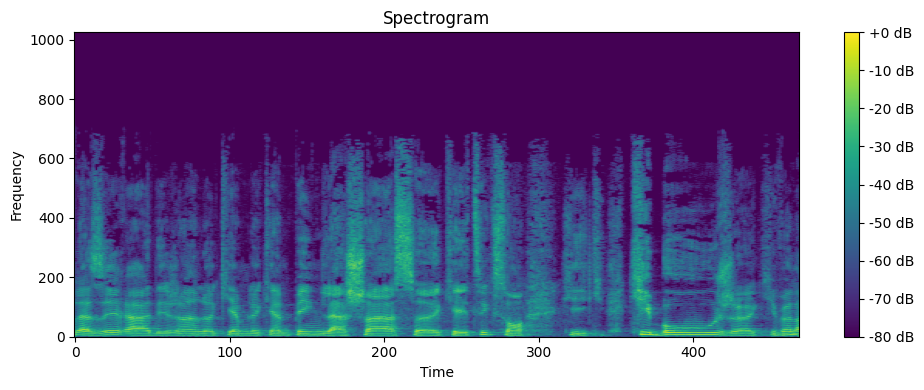

In [15]:
# Plot the spectrogram
import matplotlib.pyplot as plt

spectrogram = np.load("spectrograms/train/quebec_H_7.npy")
plt.figure(figsize=(10, 4))
plt.imshow(spectrogram, aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()